In [ ]:
"""
This file summarises & compares the input data and results from tuned models. 
The results described here pull from seperate files in which data processing & model tuning is performed ('Data' & 'Model_{} respectively) 
"""

In [7]:
import nbimporter
from Data import load_training_test_sets, data_exploration
from Model_KNN import plot_learning_curve_knn, final_model_knn
from Model_DT import plot_learning_curve_dt, final_model_dt
from Model_Adaboost import plot_learning_curve_ab, final_model_ab
from Model_SVC import plot_learning_curve_svc, final_model_svc
from Model_NN import plot_learning_curve_nn, final_model_nn
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV, ParameterGrid, KFold, cross_validate
import pandas as pd
from sklearn import preprocessing


In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Import Data

In [41]:
X_train, X_test, y_train, y_test=load_training_test_sets()

print(color.BOLD+'Test set target imbalance: '+color.END)
print(y_test.value_counts(normalize=True))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

Import Data: Complete
Train shape:  (32561, 15) 
Test shape:  (16281, 15) 
Columns:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

Process and Split Data: Complete 

Undersample data: Complete
Balanced train data:  (18664, 85)
Imbalanced test data:  (9769, 85) 

Test set target imbalance: 
0    0.758931
1    0.241069
Name: income_ >50K, dtype: float64


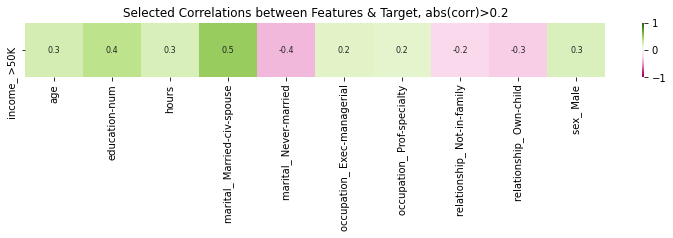

In [5]:
# The 85 resultant variables are correlated with the target to varying degrees. Figure shows 10 features for which the absolute correlation exceeds 0.2. 
# This presents an opportunity to compare the ability of algorithms to identify causal factors and classify optimally.

data_exploration(X_train, X_test, y_train, y_test, show_all_correlations=False, show_significant_correlations=True, cutoff_corr_magnitude=0.2)

In [8]:
# Create scaled features for models which require scaled data (KNN, SVC, NN)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# create dictionary in which to store results of training score, test score & runtime for each model 
res={}

## KNN

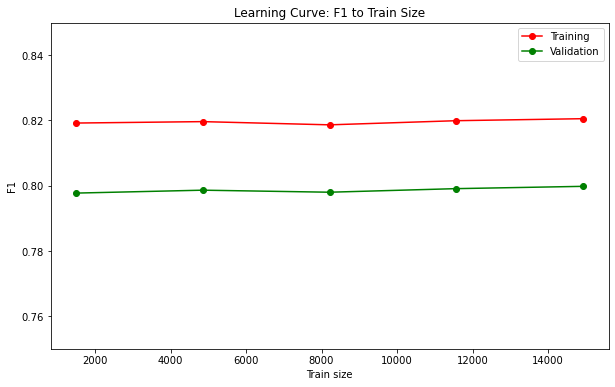

In [9]:
# There is indication of vairance since the performance on the training set is markedly above that of the validation set. 
# There is also indication of bias since the validation scores are not too high. 
# This is likely  due to the simplicity of the algorithm, or due to lacking features. 
# A greater sample size is unlikely to improve performance, since it would not correct the bias of the model. 
plot_learning_curve_knn(X_train_scaled, y_train, kf)

In [21]:
# Test performance is significantly lower than validation due to differing distributions of the target between the sets. 
# Confusion matrix shows relatively good generalization for positive class, but many misclassifications for negative class. 

res['knn']= final_model_knn(X_train_scaled, y_train,  X_test_scaled, y_test)

Train F1:  0.823 

Test F1:  0.625 

Run Time: 30.292  seconds 

Confusion Matrix:  
 [[5321 2093]
 [ 334 2021]]


## Decision Tree

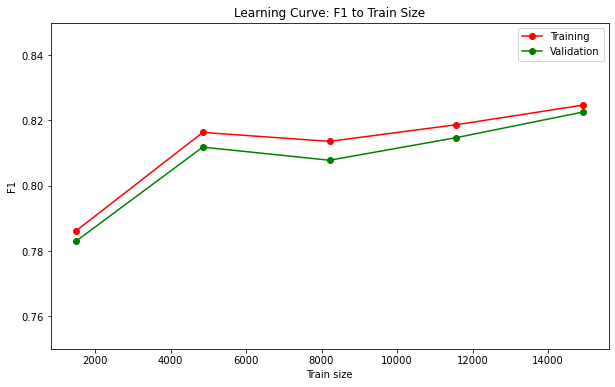

In [3]:
# There is no indication of high variance, since the training and validation scores are very similar. 
# Further, there is no indication of high bias since performance is improving with additional data. 
# This indicates the model is well pruned and is neither under nor overfitted.
# Additional data is likely to improve generalization further based on trend. 

plot_learning_curve_dt(X_train, y_train, kf)

In [4]:
# Among the most important features were ‘marital status – Married’,  ‘education-num’ and ‘capital=gain’, the former two of which 
# show the strongest correlation with the target variable (0.5 and 0.4 respectively). 
# The model predicts both classes more accurately than KNN, indicating the DT has generalized determinant factors better, which 
# is to be expected (since KNN doesn’t measure feature importance). 

res['dt']= final_model_dt(X_train, y_train,  X_test, y_test)

Train F1:  0.83 

Test F1:  0.659 

Run Time: 0.093  seconds 

Confusion Matrix:  
 [[5548 1866]
 [ 283 2072]]


## Adaboost

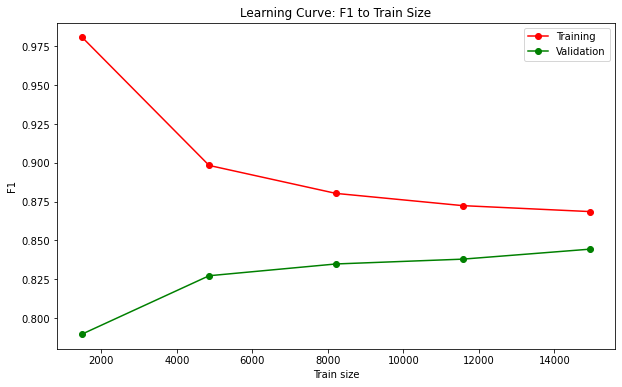

In [6]:
# The learning curve shows high variance. With a small sample, the model overfits in training so that the leaves are almost completely pure and 
# performance on the validation set is at its lowest due to failure to generalize.
# As the sample size increases the overfitting is reduced, but the high variance error remains towards the end of the sample, 
# as demonstrated by the gap between training and validation scores. T
# he addition of further data could help to continue to reduce overfitting. 

plot_learning_curve_ab(X_train, y_train, kf)

In [22]:
# Results show AB is the best performing algorithm thus far. 
# The confusion matrix shows much better classification on the negative class (majority class) in comparison to the previous algortithms. 

res['ab']  = final_model_ab(X_train, y_train,  X_test, y_test)

Train F1:  0.865 

Test F1:  0.705 

Run Time: 8.19  seconds 

Confusion Matrix:  
 [[6038 1376]
 [ 323 2032]]


## SVC

In [ ]:
# The model exhibits some variance error, which is corrected with the increase of the sample size. 
# As the data increases, overfitting is reduced, and generalization improves as demonstrated by increasing validation score.
# With the full sample size, training and testing score have almost converged. 
# The model appears to have completed learning, as shown by the relatively flat training and validation curves at the end of the training fit times.
# Most of the learning is completed in the initial iterations

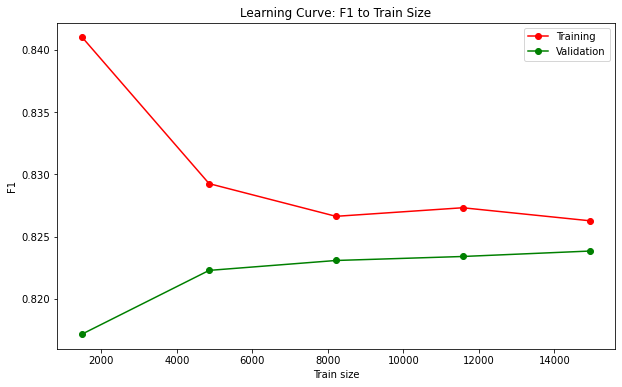

In [11]:
plot_learning_curve_svc(X_train_scaled, y_train, kf)

In [23]:
# While training performance is very similar to that of DT, test performance is inferior to the DT and similar to KNN. 
# Confusion matrix shows the majority negative class was misclassified most of the time, and more frequently than with either DT or KNN. 
# Due to this class having a greater weighting in the test set (0.75), the overall performance of SVM ranks poorer.
# This indicates the possibility of non-linear causal factors for this class (albeit tuning showed superior performance for linear kernel),
# which a non-linear model such as DT captures better. 

res['svc'] = final_model_svc(X_train_scaled, y_train,  X_test_scaled, y_test)

Train F1:  0.826 

Test F1:  0.618 

Run Time: 36.744  seconds 

Confusion Matrix:  
 [[4827 2587]
 [ 144 2211]]


## NN

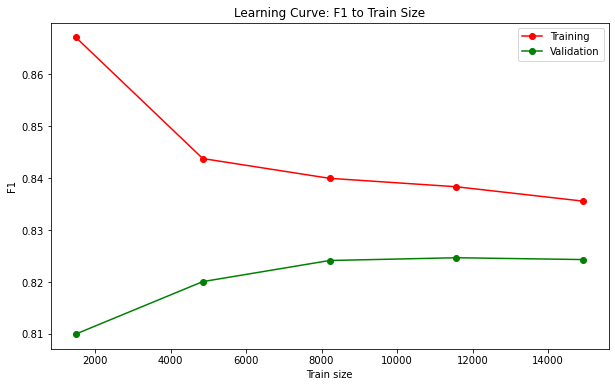

In [13]:
# As data is increased, overfitting is reduced, and the model begins to generalize better the validation performance improves. 
# Considering the ability of the activation to mute outliers, this may be driven by better representativeness of the sample with regards to the distributions 
# of X and y and implied correlations. 
# Towards the end of the sample, training performance is declining, which indicates that more data could further reduce overfitting and improve generalization.
# The curve shows that learning is at completion at the end of the iterations, as demonstrated by the relatively flat curves towards the end of the training. 
# The majority of learning is completed by approximately at 8,000 observations. 

plot_learning_curve_nn(X_train_scaled, y_train, kf)

In [24]:
# The confusion matrix shows the misclassifications are concentrated in the negative class. 
# As with previous models, its greater weight in the test sample explains the deterioration from validation performance.
# The variance error is among the highest seen in the models thus far (0.02 score difference between training and validation), 
# so it is possible that the addition of more samples will reduce overfitting and improve test score. 

res['nn'] = final_model_nn(X_train_scaled, y_train,  X_test_scaled, y_test)

Train F1:  0.834 

Test F1:  0.608 

Run Time: 10.925  seconds 

Confusion Matrix:  
 [[4667 2747]
 [ 125 2230]]


## Summary

In [ ]:
# Best performing model is Adaboost by a significant margin. 
# The reason for this appears to be lower bias, likely stemming from the following factors: 
    # Unlike KNN, feature importance is considered. 
    # A more complex model in comparison to DT, reflecting the working of the algorithm, whereby each sequential weak learner is added to reduce the error of the previous combination of learners. This adds new weak rules, which cumulate to form a strong learner. 
    # SVC fitted a linear kernel, which may not be appropriate to the data. Due to high variance, however, the non-linear kernels were found to be suboptimal. 
    # The lower bias in comparison to NN could indicate a deeper network could rival Adaboost, since the variance error between the two algorithms is comparable (based on validation set). 


# Fit times show that KNN and SVC take the longest time. 
    # In the case of KNN, this reflects the high dimensionality of the data, and the requirement for the dataset to be scanned for each new prediction. 
    # In the case of SVC, this is likely contributed to by the high C parameter, which calls for a more intricate boundary. 
    # The DT was the fastest, reflecting relatively shallow tree depth of 6 layers. Nevertheless, it is the second best performer, clearly having identified the deterministic features. 
    # Neural Networks rank in the middle, reflecting the relatively shallow network, while Adaboost requires significantly more time than DT, due to the number of weak learners and DT’s shallow depth. 

In [34]:
res= pd.DataFrame(res)
res=res.iloc[:-1, :]
res.index=['Train F1', 'Test F1', 'Runtime (s)']
res=res.transpose()

res

,Train F1,Test F1,Runtime (s)
knn,0.822709,0.624826,30.292
ab,0.864752,0.705188,8.19
svc,0.825934,0.618202,36.744
nn,0.834375,0.608292,10.925
